In [17]:
import mocet
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs, get_mm_px_scaling
scaling_mm_per_px = get_mm_px_scaling()

subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()

from numpy.polynomial.legendre import Legendre
from sklearn.linear_model import LinearRegression

def coefs_scaler(coefs_):
    trans_scale = 100 # 100x for matching scale
    coefs_new = []
    for i in range(2):
        coefs_new.append(np.array(np.concatenate([coefs_[i][:3]*trans_scale, coefs_[i][3:]])))
    return coefs_new

def make_poly_regressors(n_samples, order=2):
    X = np.ones((n_samples, 0))
    for d in range(order):
        poly = Legendre.basis(d + 1)
        poly_trend = poly(np.linspace(-1, 1, n_samples))
        X = np.hstack((X, poly_trend[:, None]))
    return X


def polynomial_detrending(pupil_data, polynomial_order):
    X = make_poly_regressors(len(pupil_data), order=polynomial_order)
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
        dedrift_regressor[:, i] = reg.predict(X)
    pupil_data = pupil_data[:, :2] - dedrift_regressor
    return pupil_data


calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']

valid_data = pickle.load(open('../../data/valid_data_list.pkl', 'rb'))

subjects = []
subjects_runs = {}
for key in list(valid_data.keys()):
    subjects.append(key[0])
    if not subjects_runs.keys().__contains__(key[0]):
        subjects_runs[key[0]] = 0
    subjects_runs[key[0]] += 1
subjects = list(set(subjects))
subjects.sort()

print(len(subjects), subjects)
print("average number of runs:", np.mean(list(subjects_runs.values())),
      "+-", np.std(list(subjects_runs.values())))

Average palpebral fissure height in mm: 10.73076923076923 ± 1.309952797378954
18 ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-015', 'sub-016', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-PBJ']
average number of runs: 7.388888888888889 +- 3.0393509703533175


In [19]:
subject_coefs_x = {}
subject_coefs_y = {}

for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                if not subject_coefs_x.keys().__contains__(subject):
                    subject_coefs_x[subject] = []
                    subject_coefs_y[subject] = []

                log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                # log, data, confound, start
                pupil_data, pupil_timestamps, pupil_confidence, pupil_diameter = mocet.utils.clean_viewpoint_data(
                    log_fname,
                    data_fname,
                    start=start,
                    duration=task_duration)

                mm_per_px = scaling_mm_per_px[(subject, session)]
                pupil_data_new = np.zeros_like(pupil_data)
                pupil_data_new[:,0] = pupil_data[:,0] - np.mean(pupil_data[:int(1.6*25*60),0])
                pupil_data_new[:,1] = pupil_data[:,1] - np.mean(pupil_data[:int(1.6*25*60),1])
                pupil_data_new = pupil_data_new * mm_per_px

                _, coefs_, _ = mocet.apply_mocet(pupil_data=pupil_data_new,
                                                 motion_params_fname=confounds_fname,
                                                 return_weights=True,
                                                 large_motion_params=False,
                                                 use_mm_deg=True,
                                                 polynomial_order=3)
                coefs_ = coefs_scaler(coefs_)
                subject_coefs_x[subject].append(coefs_[0])
                subject_coefs_y[subject].append(coefs_[1])


In [20]:
model_coefs_x = {}
model_coefs_y = {}

for subject in subjects:
    sessions = subject_pool[subject].keys()
    for session in sessions:
        runs = subject_pool[subject][session]
        root = f'{project_dir}/data/eyetracking/{subject}/{session}'
        for r in runs:
            run = f'run-{r}'
            np.random.seed(0)
            key = (subject, session, task, run)
            if key in valid_data.keys():
                if not model_coefs_x.keys().__contains__(subject):
                    model_coefs_x[subject] = []
                    model_coefs_y[subject] = []

                confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'

                simulation_root = f'../../data/simulation/1.0/{subject}/{session}'
                simulation_fname = f'{simulation_root}/{subject}_{session}_{task}_{run}_simulation-eyetracking.csv'
                simulation_data = pd.read_csv(simulation_fname)

                model_pupil_data, model_pupil_size = np.zeros((510, 2)), np.zeros((510, 1))
                # Rendered image in simulation is flipped along x-axis
                model_pupil_data[:, 0] = -simulation_data['center_x']
                model_pupil_data[:, 1] = simulation_data['center_y']
                model_pupil_size[:, 0] = simulation_data['diameter_px']

                avg_pupil_diameter_mm = 5
                pupil_diameter_mm_per_px = avg_pupil_diameter_mm / np.nanmean(model_pupil_size)
                pupil_data_new = np.zeros_like(model_pupil_data)
                pupil_data_new[:, 0] = model_pupil_data[:, 0] - np.mean(model_pupil_data[:25, 0])
                pupil_data_new[:, 1] = model_pupil_data[:, 1] - np.mean(model_pupil_data[:25, 1])
                pupil_data_new = pupil_data_new * pupil_diameter_mm_per_px

                _, coefs_, _ = mocet.apply_mocet(pupil_data=pupil_data_new,
                                                 motion_params_fname=confounds_fname,
                                                 return_weights=True,
                                                 large_motion_params=False,
                                                 use_mm_deg=True,
                                                 polynomial_order=3)
                coefs_ = coefs_scaler(coefs_)
                model_coefs_x[subject].append(coefs_[0])
                model_coefs_y[subject].append(coefs_[1])


In [21]:
from scipy.stats import ttest_rel

subjects_coefs_x = []
subjects_coefs_y = []
for key in subject_coefs_x.keys():
    subjects_coefs_x.append(np.mean(subject_coefs_x[key], axis=0))
    subjects_coefs_y.append(np.mean(subject_coefs_y[key], axis=0))

models_coefs_x = []
models_coefs_y = []
for key in subject_coefs_x.keys():
    models_coefs_x.append(np.mean(model_coefs_x[key], axis=0))
    models_coefs_y.append(np.mean(model_coefs_y[key], axis=0))

t_stat_x, p_val_x = ttest_rel(subjects_coefs_x, models_coefs_x, axis=0)
t_stat_y, p_val_y = ttest_rel(subjects_coefs_y, models_coefs_y, axis=0)

print("T-test results for X coefficients:")
print("P-value: ", p_val_x)

print("T-test results for Y coefficients:")
print("P-value: ", p_val_y)

T-test results for X coefficients:
P-value:  [1.89458712e-02 3.11542901e-01 1.64339940e-01 2.06028512e-01
 7.15081228e-07 3.17810938e-01 9.54584624e-01 1.01949245e-01
 1.89460390e-01 5.21030957e-01]
T-test results for Y coefficients:
P-value:  [2.14529813e-01 8.66927273e-02 1.27503143e-01 2.68282977e-01
 2.16474073e-02 1.55121728e-01 2.71150086e-01 5.55137014e-01
 2.68322960e-06 1.30604685e-02]


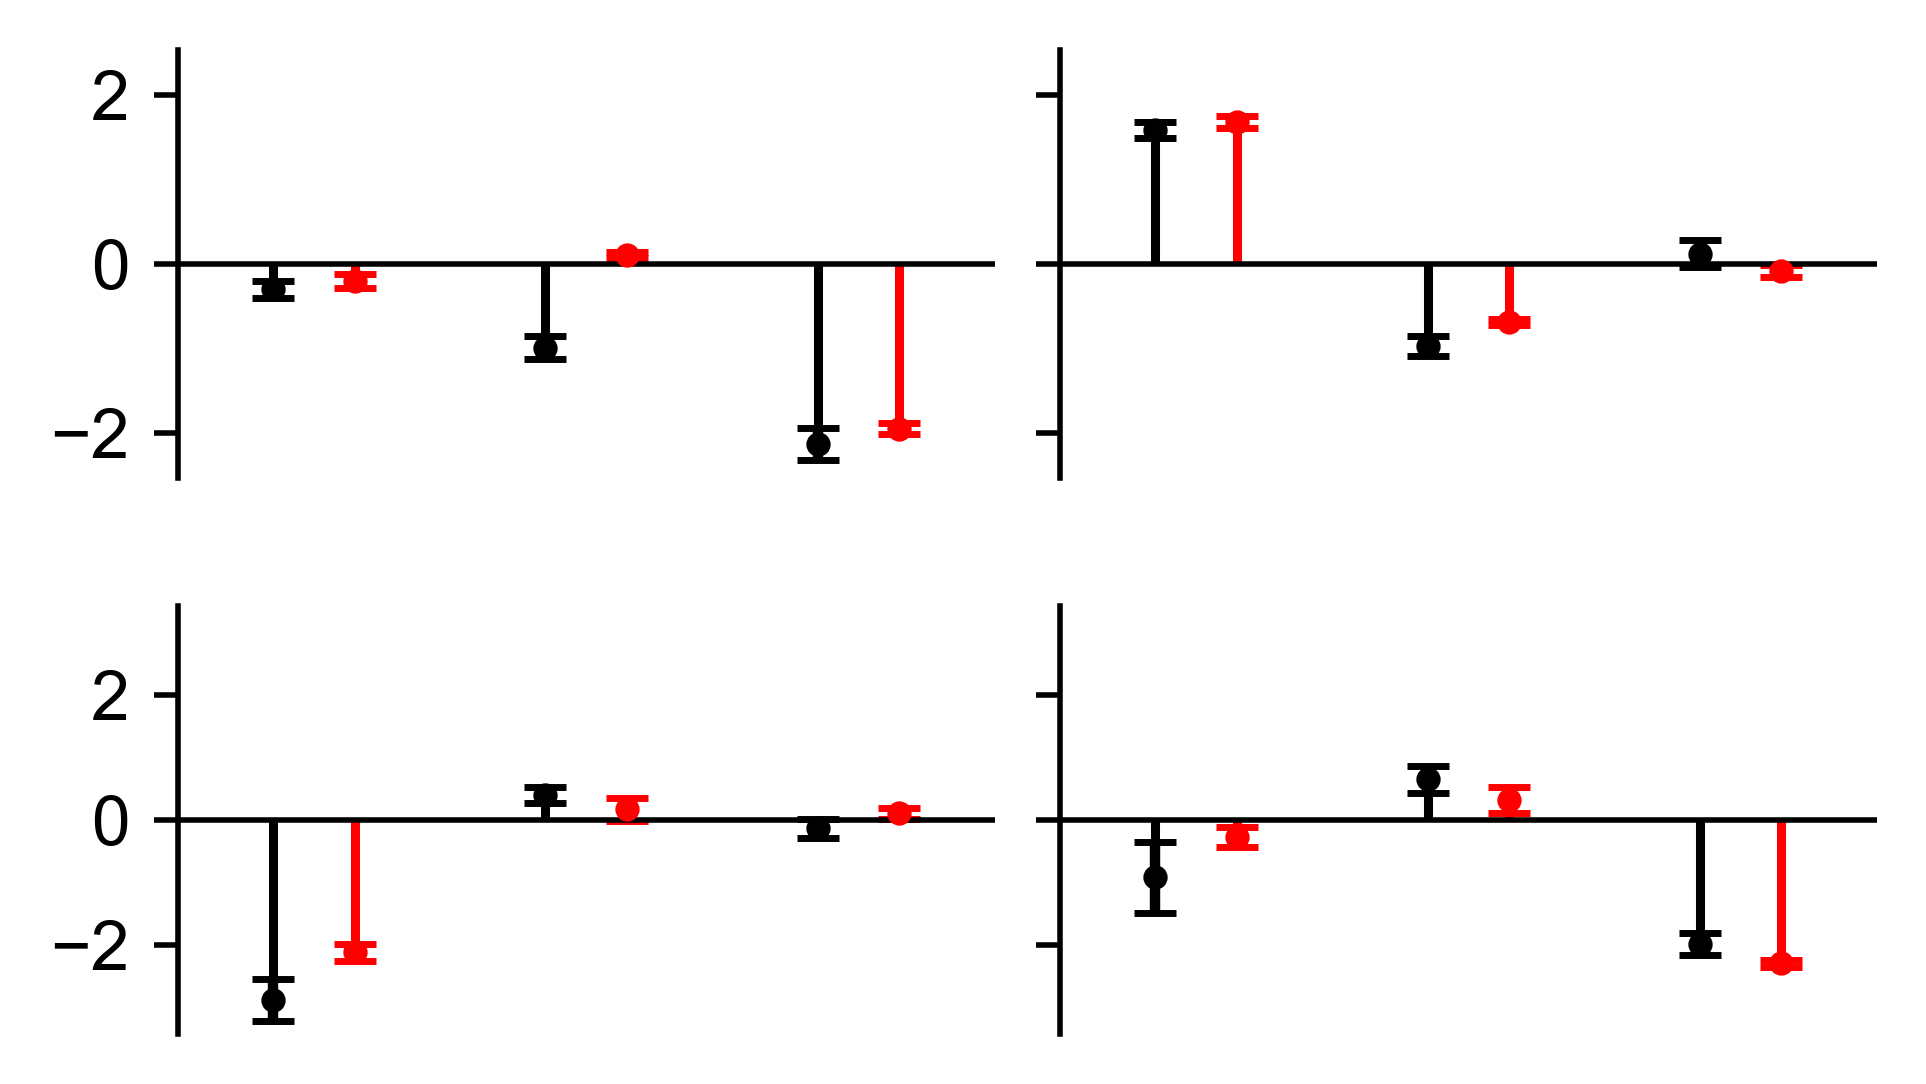

In [23]:
from scipy.stats import sem
import matplotlib.pyplot as plt

plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(4,2.5), dpi=500, sharey='row', sharex=True)
offset = 0.15
markersize = 5
capsize = 3

def draw_vlines(ax, positions, means, color):
    for pos, mean in zip(positions, means):
        ax.vlines(pos, 0, mean, colors=color, linewidth=1.3)
axes_row0 = axes[1]
axes_row1 = axes[0]

positions = np.arange(3) - offset
means_x = np.mean(subjects_coefs_x, axis=0).ravel()[:3]
axes_row0[0].errorbar(positions, means_x, yerr=sem(subjects_coefs_x, axis=0).ravel()[:3],
                   capsize=capsize, fmt=".", c="k", markersize=markersize)
draw_vlines(axes_row0[0], positions, means_x, color="k")

means_y = np.mean(subjects_coefs_y, axis=0).ravel()[:3]
axes_row0[1].errorbar(positions, means_y, yerr=sem(subjects_coefs_y, axis=0).ravel()[:3],
                   capsize=capsize, fmt=".", c="k", markersize=markersize)
draw_vlines(axes_row0[1], positions, means_y, color="k")

positions = np.arange(3) + offset
means_x = np.mean(models_coefs_x, axis=0).ravel()[:3]
axes_row0[0].errorbar(positions, means_x, yerr=sem(models_coefs_x, axis=0).ravel()[:3],
                   capsize=capsize, fmt=".", c="r", markersize=markersize)
draw_vlines(axes_row0[0], positions, means_x, color="r")

means_y = np.mean(models_coefs_y, axis=0).ravel()[:3]
axes_row0[1].errorbar(positions, means_y, yerr=sem(models_coefs_y, axis=0).ravel()[:3],
                   capsize=capsize, fmt=".", c="r", markersize=markersize)
draw_vlines(axes_row0[1], positions, means_y, color="r")

# Draw error bars and vertical lines for the remaining coefficients
positions = np.arange(3) - offset
means_x = np.mean(subjects_coefs_x, axis=0).ravel()[3:6]
axes_row1[0].errorbar(positions, means_x, yerr=sem(subjects_coefs_x, axis=0).ravel()[3:6],
                   capsize=capsize, fmt=".", c="k", markersize=markersize)
draw_vlines(axes_row1[0], positions, means_x, color="k")

means_y = np.mean(subjects_coefs_y, axis=0).ravel()[3:6]
axes_row1[1].errorbar(positions, means_y, yerr=sem(subjects_coefs_y, axis=0).ravel()[3:6],
                   capsize=capsize, fmt=".", c="k", markersize=markersize)
draw_vlines(axes_row1[1], positions, means_y, color="k")

positions = np.arange(3) + offset
means_x = np.mean(models_coefs_x, axis=0).ravel()[3:6]
axes_row1[0].errorbar(positions, means_x, yerr=sem(models_coefs_x, axis=0).ravel()[3:6],
                   capsize=capsize, fmt=".", c="r", markersize=markersize)
draw_vlines(axes_row1[0], positions, means_x, color="r")

means_y = np.mean(models_coefs_y, axis=0).ravel()[3:6]
axes_row1[1].errorbar(positions, means_y, yerr=sem(models_coefs_y, axis=0).ravel()[3:6],
                   capsize=capsize, fmt=".", c="r", markersize=markersize)
draw_vlines(axes_row1[1], positions, means_y, color="r")

plt.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.3)

for ax in axes.flatten():
    ax.set_xlim((-0.5, 2.5))
    ax.set_yticks([-2, 0, 2])
    ax.set_xticks(np.arange(3))
    ax.set_xticklabels([''] * 3)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.8)
    y_max = max(abs(ax.get_ylim()[0]), abs(ax.get_ylim()[1]))
    ax.set_ylim(-y_max, y_max)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False)

plt.show()
